In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch

from sbi import utils as utils
from sbi.analysis import pairplot
from sbi.inference import NSPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [4]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="vp")

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=5_000)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
score_estimator = inference.train(stop_after_epochs=300, training_batch_size=100)
posterior = inference.build_posterior(score_estimator)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 1290 epochs.

/root/sbi/sbi/inference/posteriors/score_posterior.py:62: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  super().__init__(


For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/root/sbi/tutorials/sbi-logs/NSPE/2024-07-20T19_57_36.522564' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='epochs_trained', ylabel='training_loss'>,
        <Axes: xlabel='epochs_trained', ylabel='validation_loss'>],
       dtype=object))

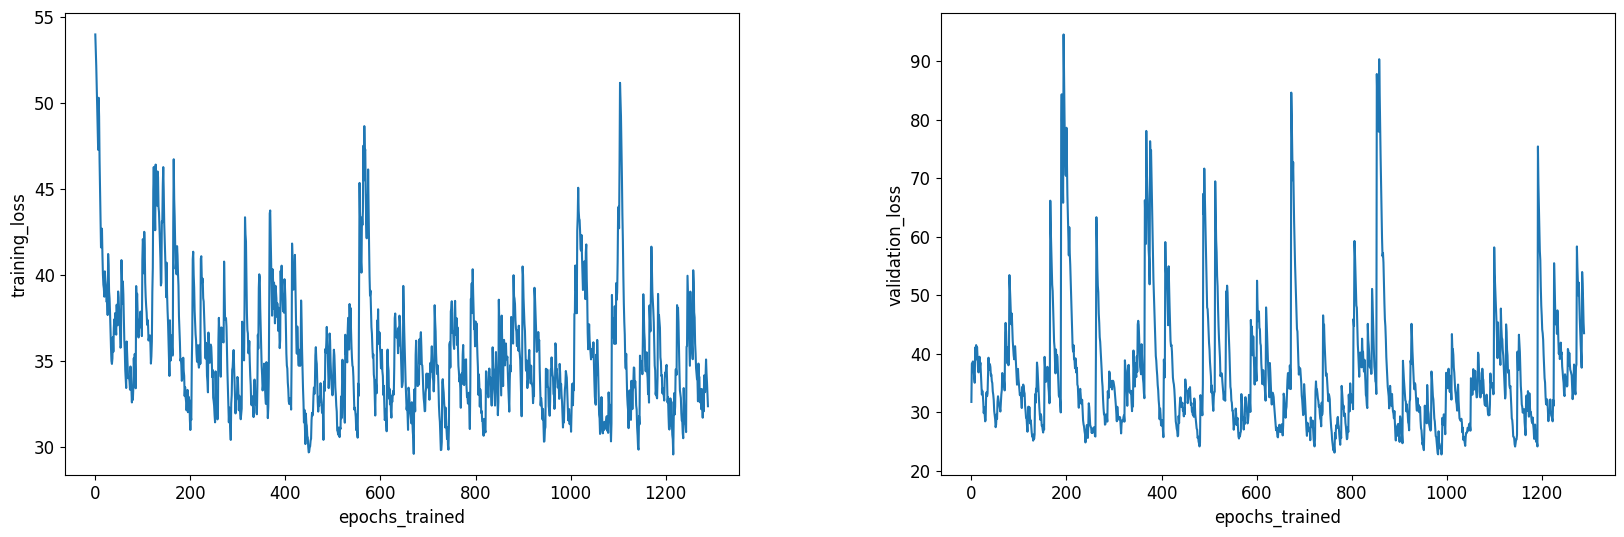

In [6]:
from sbi.analysis import plot_summary

plot_summary(inference, tags=["training_loss", "validation_loss"])

In [7]:
posterior = inference.build_posterior(score_estimator)

In [8]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

In [9]:
from sbi.samplers.score.predictors import DDIM, EulerMaruyama 


In [11]:
samples = posterior.sample((1000,), x=x_obs, steps=100)

Drawing 1000 posterior samples:   0%|          | 0/99 [00:00<?, ?it/s]

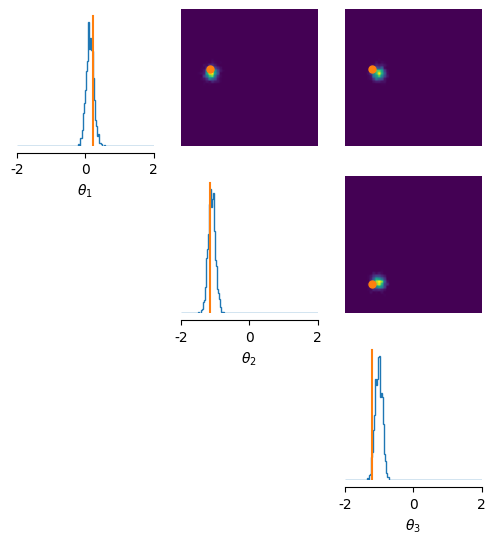

In [12]:
#samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [260]:
!pip install sbibm --no-deps

In [7]:
from sbibm.tasks import get_task

task = get_task("two_moons")

prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((10_000,))
xs = simulator(thetas)


In [8]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="subvp")
inference = inference.append_simulations(thetas, xs)

# train the density estimator and build the posterior
score_estimator = inference.train(stop_after_epochs=500, training_batch_size=100)
posterior = inference.build_posterior(score_estimator)

 Neural network successfully converged after 2673 epochs.

/root/sbi/sbi/inference/posteriors/score_posterior.py:62: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  super().__init__(


In [11]:
# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Apache License Version 2.0, see <https://www.apache.org/licenses/>

from __future__ import annotations

from typing import Tuple

import pytest
import torch
from torch import Tensor

from sbi.neural_nets.score_nets import build_score_estimator
from sbi.inference.potentials.score_based_potential import (
    score_estimator_based_potential_gradient,
)
from sbi.samplers.score.score import Diffuser


@pytest.mark.parametrize(
    "sde_type",
    [
        "vp",
        "ve",
        "subvp",
    ],
)
@pytest.mark.parametrize("input_event_shape", ((1,), (4,)))
@pytest.mark.parametrize("std", (1.0, 0.1))
def test_score_estimator_forward_shapes(sde_type, input_event_shape, std):

    mean0 = torch.zeros(input_event_shape)
    std0 = std * torch.ones(input_event_shape)

    score_fn = _build_gaussian_score_estimator(sde_type, input_event_shape, mean0, std0)

    sampler = Diffuser(score_fn, "euler_maruyama", None)

    T_min = score_fn.score_estimator.T_min
    T_max = score_fn.score_estimator.T_max
    ts = torch.linspace(T_max, T_min, 1000)
    samples = sampler.run(10_000, ts)

    mean_est = samples[0].mean(0)
    std_est = samples[0].std(0)

    # TODO: Fix this

    # print(mean_est, std_est)
    # assert torch.allclose(mean_est, torch.zeros_like(mean_est), rtol=1e-3)
    # assert torch.allclose(std_est, torch.ones_like(mean_est) * std, rtol=1e-3)


def _build_gaussian_score_estimator(
    sde_type: str,
    input_event_shape: Tuple[int],
    mean0: Tensor,
    std0: Tensor,
):
    """Helper function for all tests that deal with shapes of density estimators."""

    # Use discrete thetas such that categorical density esitmators can also use them.
    building_thetas = (
        torch.randint(0, 4, (1000, *input_event_shape), dtype=torch.float32) * std0
        + mean0
    )
    building_xs = torch.ones((1000, 1))

    class DummyNet(torch.nn.Module):
        def forward(self, x):
            return torch.zeros((x.shape[0], *input_event_shape))

    score_estimator = build_score_estimator(
        building_thetas,
        building_xs,
        sde_type=sde_type,
        score_net=DummyNet(),
    )

    score_fn, _ = score_estimator_based_potential_gradient(
        score_estimator, prior=None, x_o=torch.ones((1,))
    )

    return score_fn


For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/root/sbi/tutorials/sbi-logs/NSPE/2024-07-21T18_13_17.003344' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


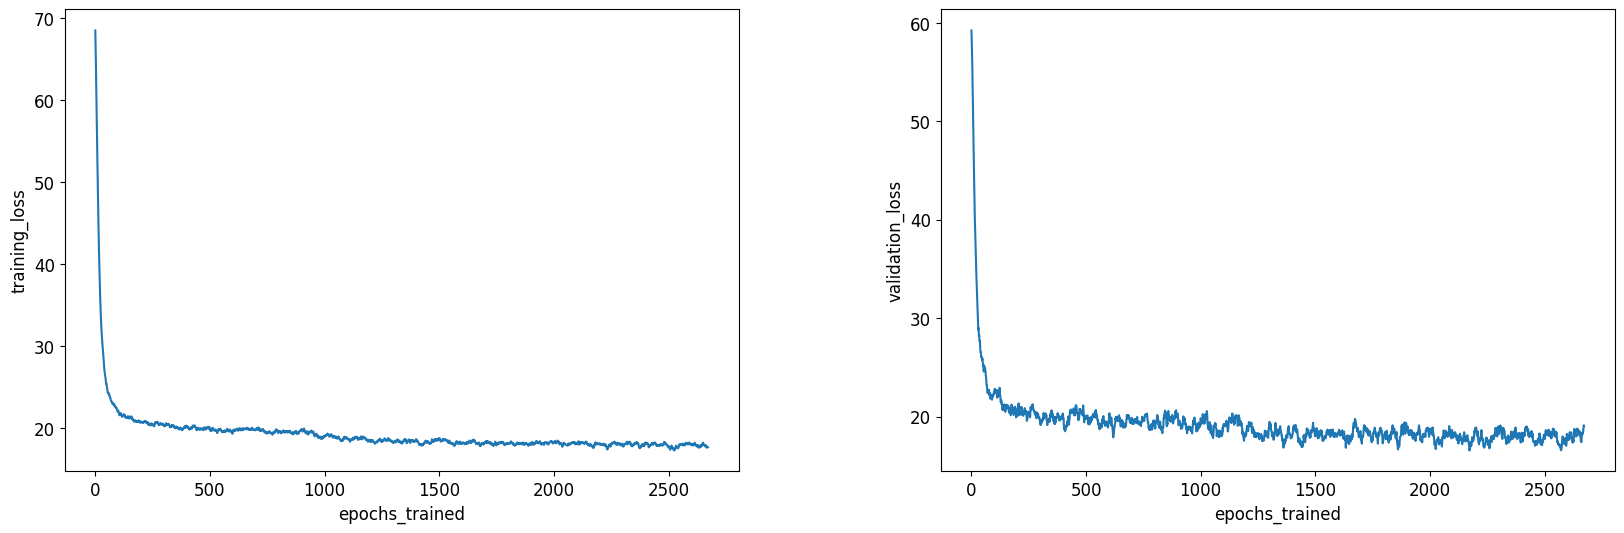

In [12]:
from sbi.analysis import plot_summary

_ = plot_summary(inference, tags=["training_loss", "validation_loss"])

In [13]:
score_estimator.std_fn(score_estimator.T_min*torch.ones((1,)))

tensor([[0.0006]])

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

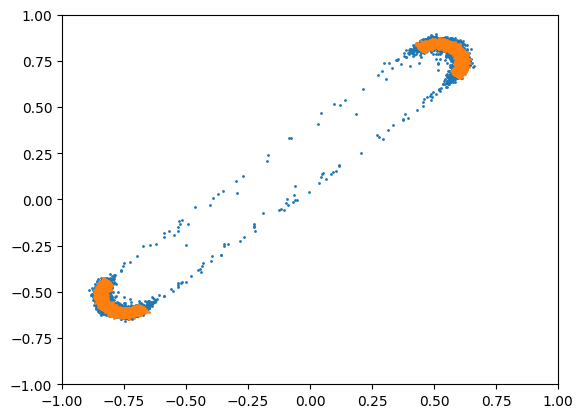

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

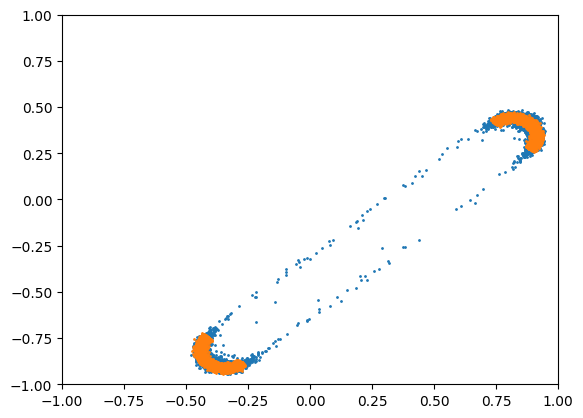

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

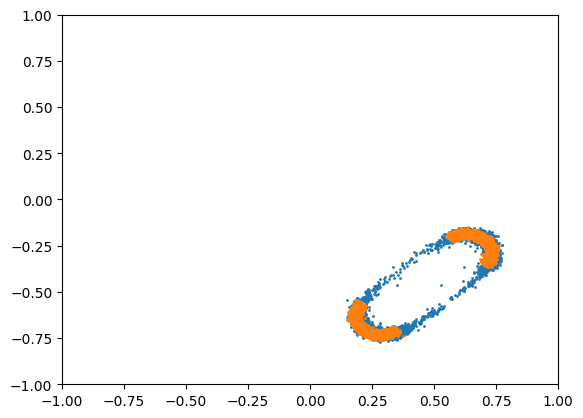

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

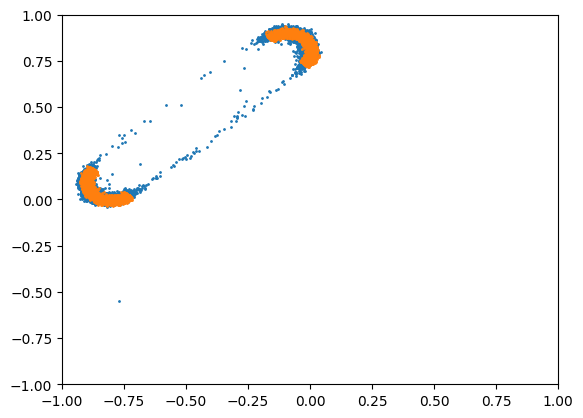

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

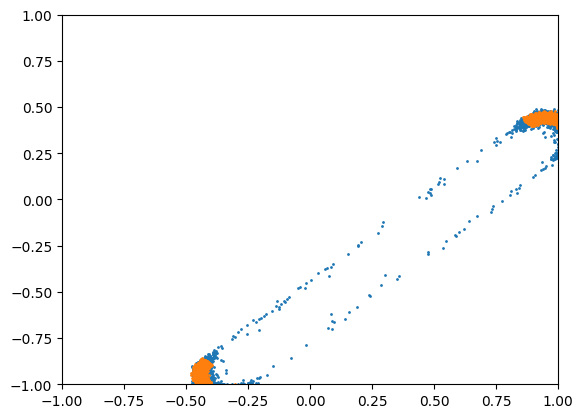

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

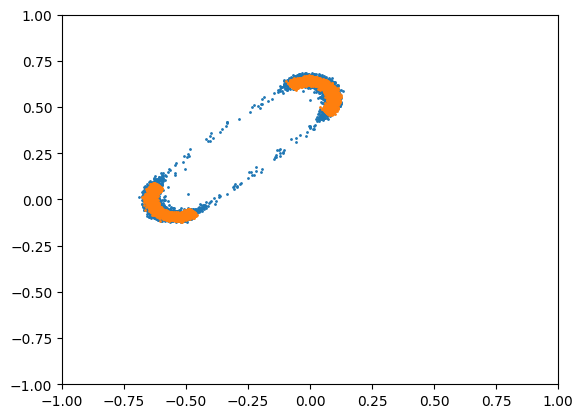

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

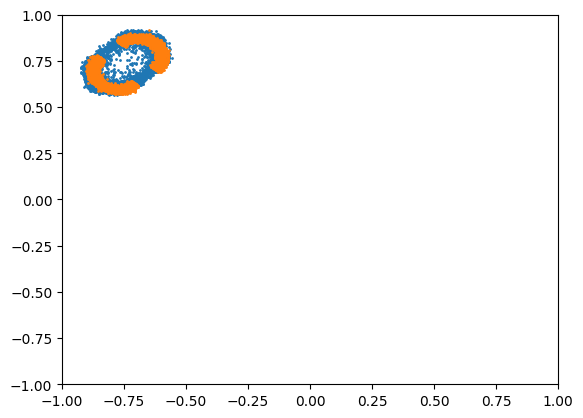

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

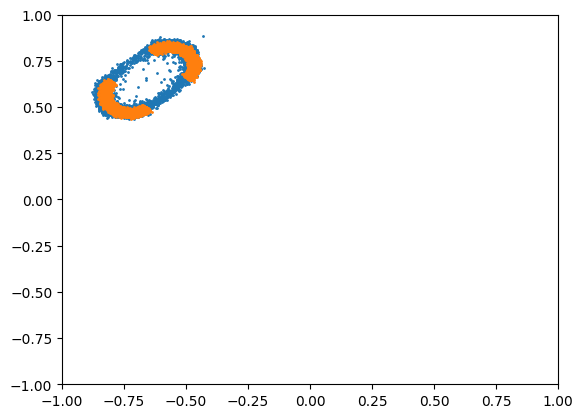

Drawing 10000 posterior samples:   0%|          | 0/999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
from sbi.utils.metrics import c2st 
import matplotlib.pyplot as plt

for i in range(1,11):
    ref_samples = task.get_reference_posterior_samples(i)
    x_obs = task.get_observation(i)
    samples = posterior.sample((10000,), x=x_obs, steps=1000)
    #print(c2st(ref_samples, samples))
    plt.scatter(samples[:,0], samples[:,1],s=1)
    plt.scatter(ref_samples[:,0], ref_samples[:,1], s=1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show()

In [4]:
# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Apache License Version 2.0, see <https://www.apache.org/licenses/>

from __future__ import annotations

from typing import Tuple

import pytest
import torch
from torch import Tensor

from sbi.neural_nets.score_nets import build_score_estimator
from sbi.inference.potentials.score_based_potential import (
    score_estimator_based_potential_gradient,
)
from sbi.samplers.score.score import Diffuser


@pytest.mark.parametrize(
    "sde_type",
    [
        "vp",
        "ve",
        "subvp",
    ],
)
@pytest.mark.parametrize("input_event_shape", ((1,), (4,)))
@pytest.mark.parametrize("std", (1.0, 0.1))
def test_score_estimator_forward_shapes(sde_type, input_event_shape, std):

    mean0 = torch.zeros(input_event_shape)
    std0 = std * torch.ones(input_event_shape)

    score_fn = _build_gaussian_score_estimator(sde_type, input_event_shape, mean0, std0)

    sampler = Diffuser(score_fn, "euler_maruyama", None)

    T_min = score_fn.score_estimator.T_min
    T_max = score_fn.score_estimator.T_max
    ts = torch.linspace(T_max, T_min, 1000)
    samples = sampler.run(10_000, ts)

    mean_est = samples[0].mean(0)
    std_est = samples[0].std(0)

    # TODO: Fix this

    # print(mean_est, std_est)
    # assert torch.allclose(mean_est, torch.zeros_like(mean_est), rtol=1e-3)
    # assert torch.allclose(std_est, torch.ones_like(mean_est) * std, rtol=1e-3)



def _build_gaussian_score_estimator(
    sde_type: str,
    input_event_shape: Tuple[int],
    mean0: Tensor,
    std0: Tensor,
):
    """Helper function for all tests that deal with shapes of density estimators."""

    # Use discrete thetas such that categorical density esitmators can also use them.
    building_thetas = (
        torch.randn((1000, *input_event_shape), dtype=torch.float32) * std0
        + mean0
    )
    building_xs = torch.ones((1000, 1))

    class DummyNet(torch.nn.Module):
        def forward(self, x):
            return torch.zeros((x.shape[0], *input_event_shape))
    

    score_estimator = build_score_estimator(
        building_thetas,
        building_xs,
        sde_type=sde_type,
        score_net=DummyNet(),
    )
    

    score_fn, _ = score_estimator_based_potential_gradient(
        score_estimator, prior=None, x_o=torch.ones((1,))
    )

    return score_fn


In [16]:
input_event_shape = (1,)
std = 1.
sde_type="ve"

mean0 = torch.zeros(input_event_shape)
std0 = std * torch.ones(input_event_shape)

score_fn = _build_gaussian_score_estimator(sde_type, input_event_shape, mean0, std0)

sampler = Diffuser(score_fn, "ddim", None)

T_min = score_fn.score_estimator.T_min
T_max = score_fn.score_estimator.T_max
ts = torch.linspace(T_max, T_min, 500)
samples = sampler.run(10_000, ts)

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

tensor([0.4870])
tensor([0.4744])
tensor([0.4621])
tensor([0.4501])
tensor([0.4385])
tensor([0.4271])
tensor([0.4160])
tensor([0.4052])
tensor([0.3947])
tensor([0.3845])
tensor([0.3745])
tensor([0.3648])
tensor([0.3553])
tensor([0.3461])
tensor([0.3372])
tensor([0.3284])
tensor([0.3199])
tensor([0.3116])
tensor([0.3035])
tensor([0.2957])
tensor([0.2880])
tensor([0.2805])
tensor([0.2732])
tensor([0.2662])
tensor([0.2593])
tensor([0.2525])
tensor([0.2460])
tensor([0.2396])
tensor([0.2334])
tensor([0.2273])
tensor([0.2215])
tensor([0.2157])
tensor([0.2101])
tensor([0.2047])
tensor([0.1994])
tensor([0.1942])
tensor([0.1892])
tensor([0.1843])
tensor([0.1795])
tensor([0.1748])
tensor([0.1703])
tensor([0.1659])
tensor([0.1616])
tensor([0.1574])
tensor([0.1533])
tensor([0.1493])
tensor([0.1455])
tensor([0.1417])
tensor([0.1380])
tensor([0.1344])
tensor([0.1309])
tensor([0.1276])
tensor([0.1242])
tensor([0.1210])
tensor([0.1179])
tensor([0.1148])
tensor([0.1119])
tensor([0.1089])
tensor([0.1061

In [17]:
mean_est = samples[0].mean(0)
std_est = samples[0].std(0)

print(mean_est, std_est)

tensor([-0.0100]) tensor([1.0087])


In [18]:
mean_est

tensor([-0.0100])

In [144]:
score_fn(torch.ones((1,)),1e-3* torch.ones((1,)))

tensor([[-0.2462]])

(array([  28.,  174.,  622., 1544., 2602., 2464., 1665.,  677.,  192.,
          32.]),
 array([-0.35513294, -0.28452909, -0.21392524, -0.14332139, -0.07271755,
        -0.0021137 ,  0.06849015,  0.139094  ,  0.20969784,  0.28030169,
         0.35090554]),
 <BarContainer object of 10 artists>)

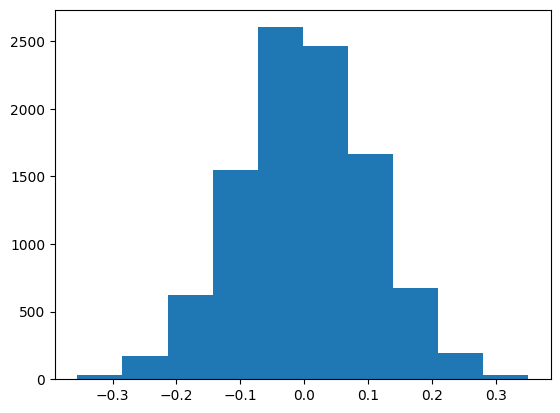

In [45]:
plt.hist(samples.flatten().numpy())

In [19]:
from sbi import utils
from sbi.inference import SNPE, infer

import torch

# Example is taken from 00_getting_started.ipynb
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

posterior = infer(simulator, prior, method="SNPE_A", num_simulations=10)
assert posterior is not None, "Most basic use of 'infer' failed"
posterior = infer(
    simulator,
    prior,
    method="SNPE_A",
    num_simulations=10,
    init_kwargs={"num_components": 5},
    train_kwargs={"max_num_epochs": 2},
    build_posterior_kwargs={"prior": prior},
)
assert posterior is not None, "Using 'infer' with keyword arguments failed"

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 174 epochs.

AssertionError: If you pass a `Callable` as `potential_fn` then it must have `theta` and `x_o` as inputs, even if some of these keyword arguments are unused.

In [21]:
import pytest
from pyro.infer.mcmc import MCMC
from torch import Tensor, eye, zeros
from torch.distributions import MultivariateNormal

from sbi.inference import (
    SNL,
    MCMCPosterior,
    likelihood_estimator_based_potential,
    simulate_for_sbi,
)
from sbi.samplers.mcmc import PyMCSampler, SliceSamplerSerial, SliceSamplerVectorized
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
from sbi.utils.user_input_checks import process_prior, process_simulator


In [25]:

sampling_method: str = "slice_np_vectorized"
num_chains: int = 4,
mcmc_params_fast: dict = {}
num_dim: int = 2
num_samples: int = 42
num_trials: int = 2
num_simulations: int = 10

x_o = zeros((num_trials, num_dim))
mcmc_params_fast["num_chains"] = num_chains

prior = MultivariateNormal(loc=zeros(num_dim), covariance_matrix=eye(num_dim))
simulator = diagonal_linear_gaussian

inference = SNL(prior, show_progress_bars=False)

prior, _, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
theta, x = simulate_for_sbi(
    simulator, prior, num_simulations, simulation_batch_size=10
)
estimator = inference.append_simulations(theta, x).train(max_num_epochs=5)
potential_fn, transform = likelihood_estimator_based_potential(
    estimator, prior, x_o
)
posterior = MCMCPosterior(
    potential_fn, theta_transform=transform, method=sampling_method, proposal=prior
)

assert posterior.posterior_sampler is None
samples = posterior.sample(
    sample_shape=(num_samples, num_chains),
    x=x_o,
    mcmc_parameters={"init_strategy": "prior", **mcmc_params_fast},
)
# assert isinstance(samples, Tensor)
# assert samples.shape == (num_samples, num_chains, num_dim)

# if "pyro" in sampling_method:
#     assert type(posterior.posterior_sampler) is MCMC
# elif "pymc" in sampling_method:
#     assert type(posterior.posterior_sampler) is PyMCSampler
# elif sampling_method == "slice_np":
#     assert type(posterior.posterior_sampler) is SliceSamplerSerial
# else:  # sampling_method == "slice_np_vectorized"
#     assert type(posterior.posterior_sampler) is SliceSamplerVectorized


  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: The `x` passed to condition the posterior for evaluation or sampling
                has an inferred batch shape larger than one. This is not supported in
                some sbi methods for reasons depending on the scenario:

                    - in case you want to evaluate or sample conditioned on several iid
                      xs e.g., (p(theta | [x1, x2, x3])), this is fully supported only
                      for likelihood based SNLE and SNRE. For SNPE it is supported only
                      for a fixed number of trials and using an appropriate embedding
                      net, i.e., by treating the trials as additional data dimension. In
                      that case, make sure to pass xo with a leading batch dimensionen.

                    - in case you trained with a single round to do amortized inference
                    and now you want to evaluate or sample a given theta conditioned on
                    several xs, one after the other, e.g, p(theta | x1), p(theta | x2),
                    p(theta| x3): this broadcasting across xs is not supported in sbi.
                    Instead, what you can do it to call posterior.log_prob(theta, xi)
                    multiple times with different xi.

                    - finally, if your observation is multidimensional, e.g., an image,
                    make sure to pass it with a leading batch dimension, e.g., with
                    shape (1, xdim1, xdim2). Beware that the current implementation
                    of sbi might not provide stable support for this and result in
                    shape mismatches.

            NOTE: below we use list notation to reduce clutter, but `x` should be of
            type torch.Tensor or ndarray.

            For example:

            > x_o = [[1]]
            > x_o = [[1, 2, 3]]

            are interpreted as single observations with a leading batch dimension of
            one. However

            > x_o = [ [1], [2] ]
            > x_o = [ [1,2,3], [4,5,6] ]

            are interpreted as a batch of two scalar or vector observations, which
            is not supported yet. The following is interpreted as a matrix-shaped
            observation, e.g. a monochromatic image:

            > x_o = [ [[1,2,3], [4,5,6]] ]

            Finally, for convenience,

            > x_o = [1]
            > x_o = [1, 2, 3]

            will be interpreted as a single scalar or single vector observation
            respectively, without the user needing to wrap or unsqueeze them.
            

In [27]:
posterior.default_x.shape

torch.Size([2, 2])